# Лабораторная работа №2

"Наивный" байесовский классификатор.

## 0\. Импортировать необходимые модули:

In [11]:
%matplotlib inline

from typing import Any

import pandas as pd
import numpy as np
from sklearn.naive_bayes import CategoricalNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt

plt.rcParams.update({"figure.max_open_warning": 0})

### 1\.1\. Загрузить таблицу "Mushroom" из репозитория UCI.

In [12]:
mushroom_dataframe = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data", header=None)

mushroom_dataframe

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,k,s,n,f,n,a,c,b,y,...,s,o,o,p,o,o,p,b,c,l
8120,e,x,s,n,f,n,a,c,b,y,...,s,o,o,p,n,o,p,b,v,l
8121,e,f,s,n,f,n,a,c,b,n,...,s,o,o,p,o,o,p,b,c,l
8122,p,k,y,n,f,y,f,c,n,b,...,k,w,w,p,w,o,e,w,v,l


### 1\.2\. Вычислить и визуализировать распределения значений категориальных признаков по классам.

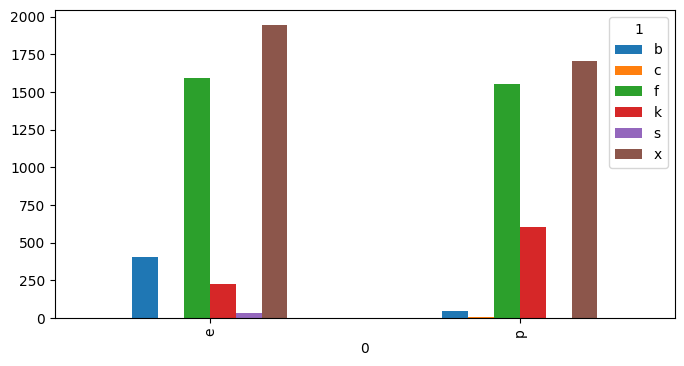

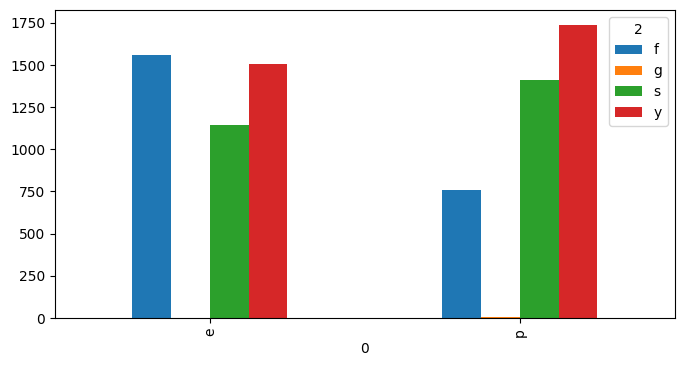

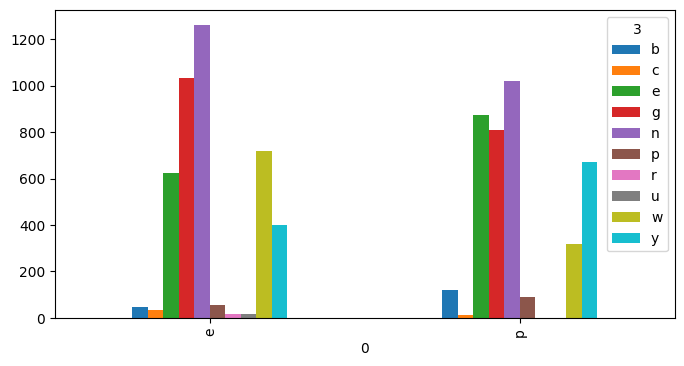

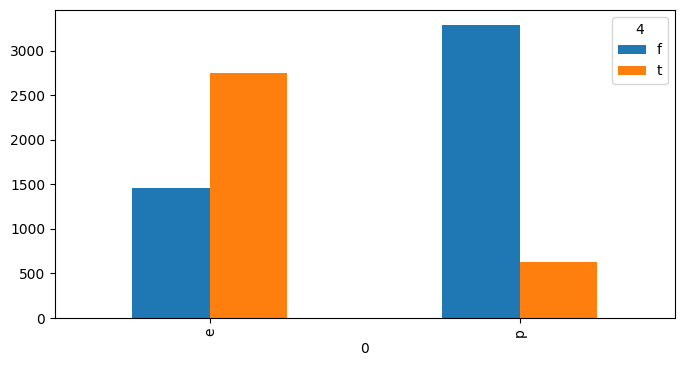

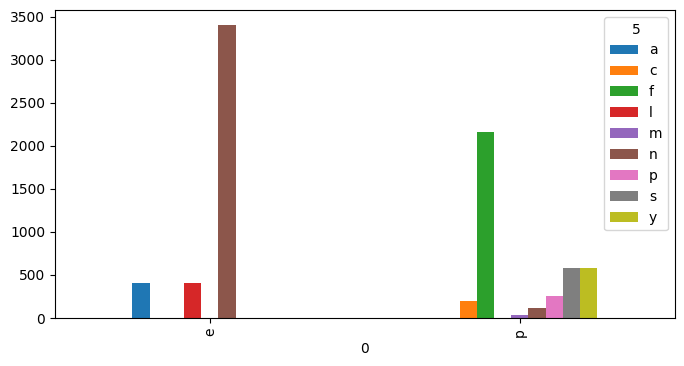

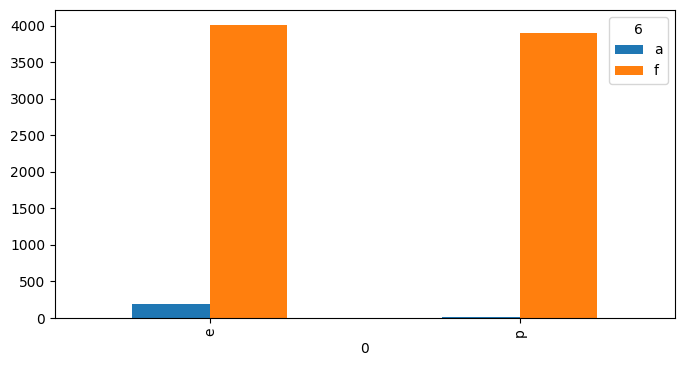

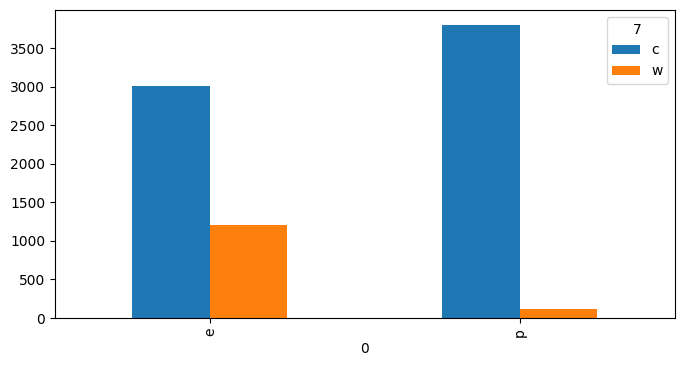

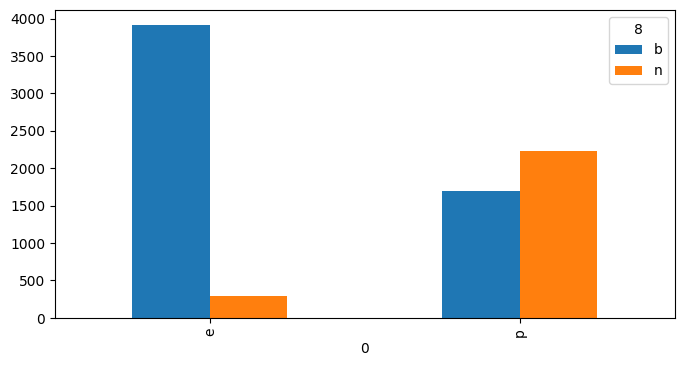

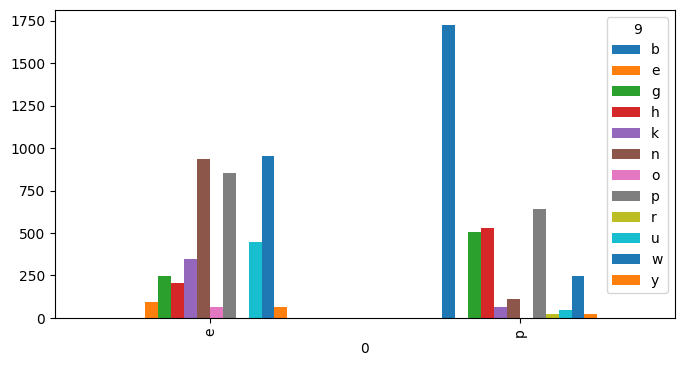

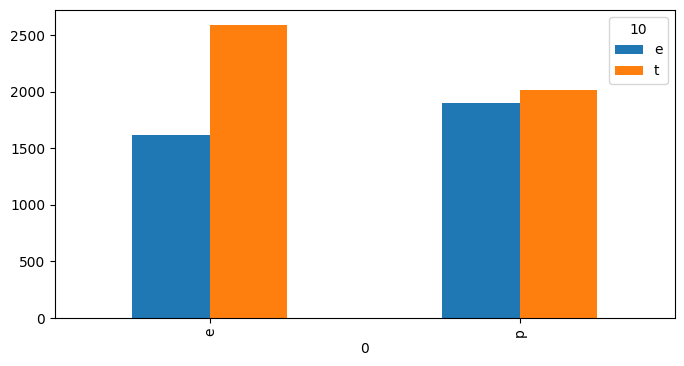

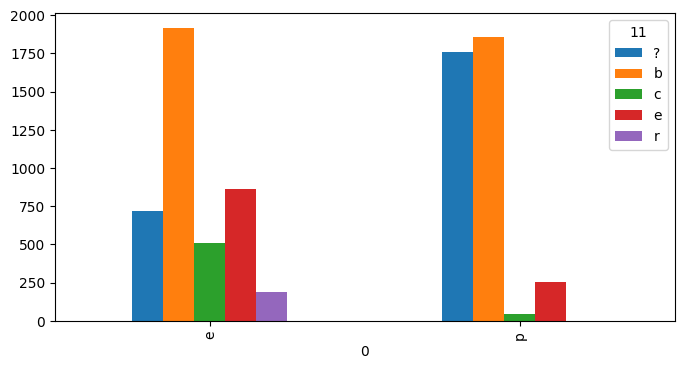

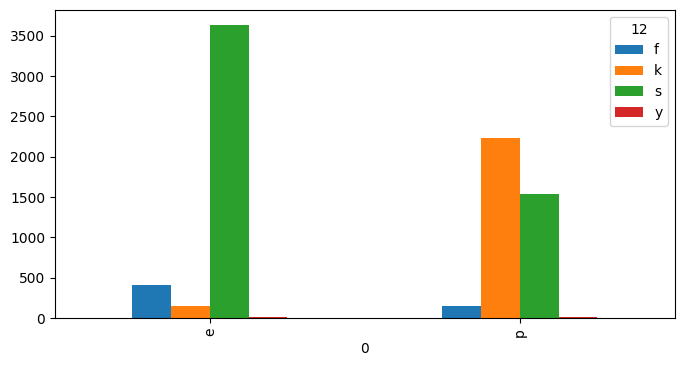

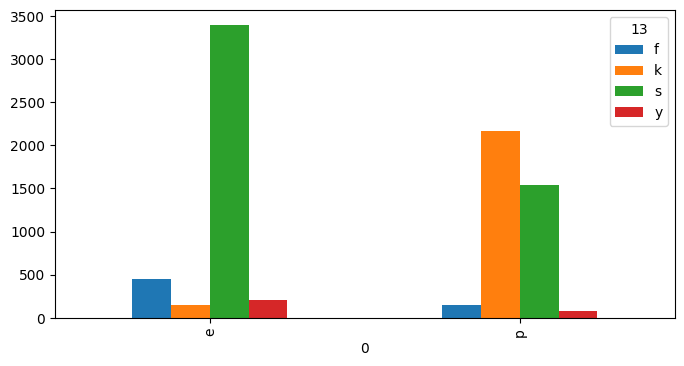

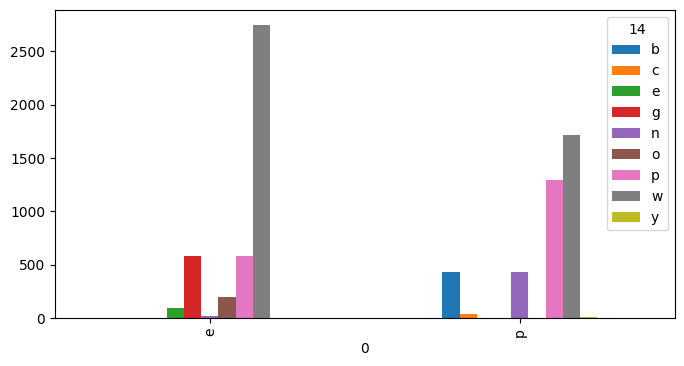

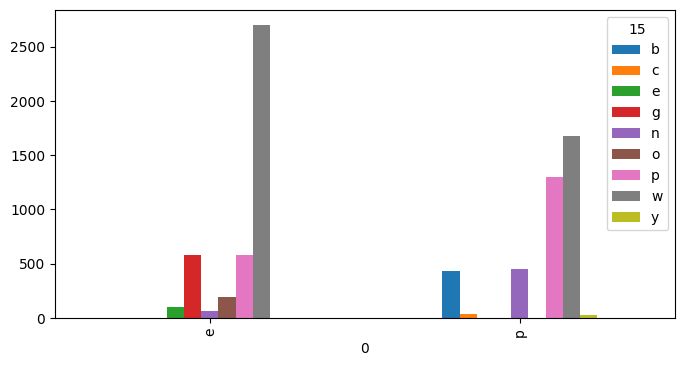

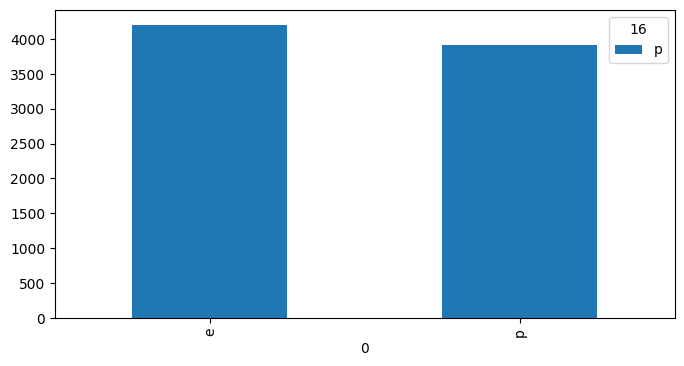

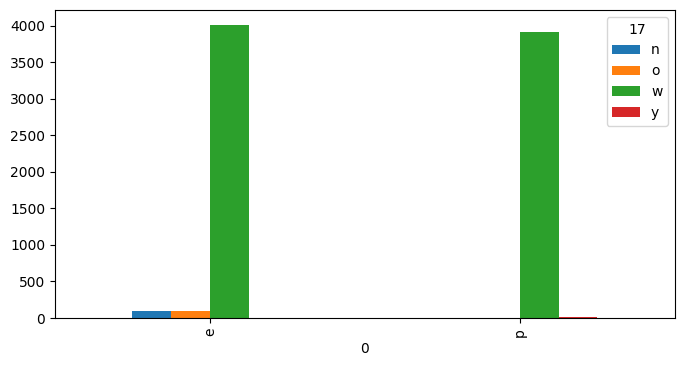

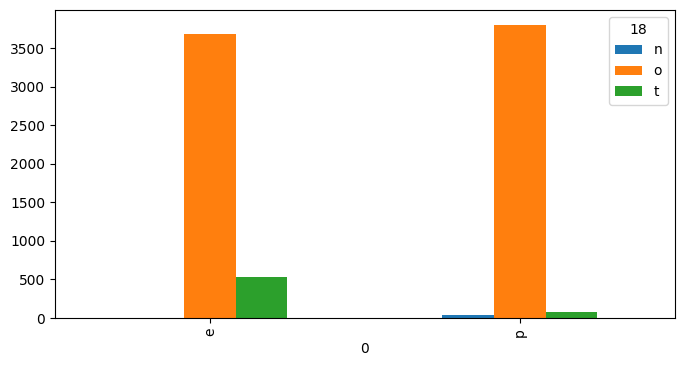

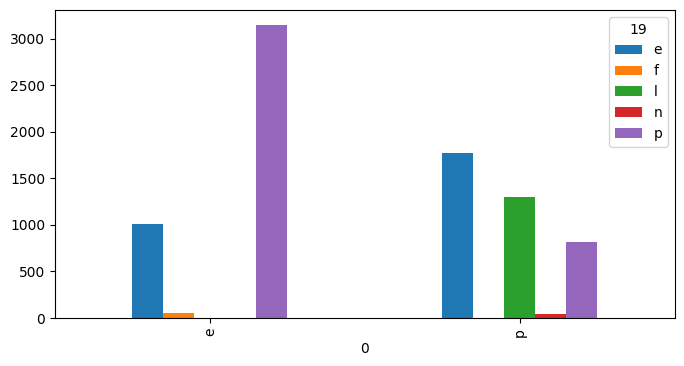

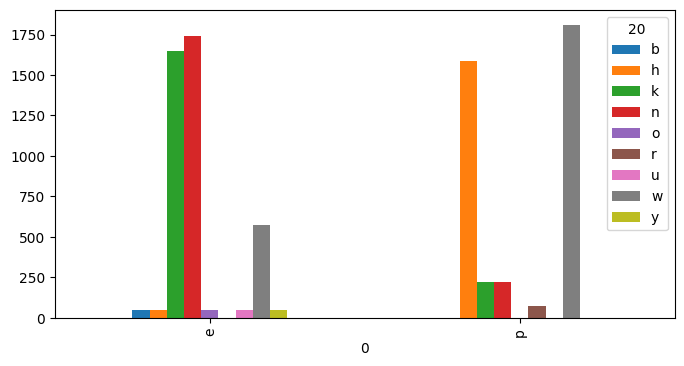

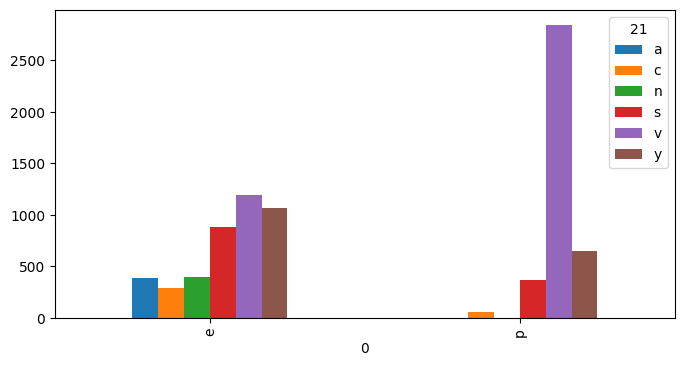

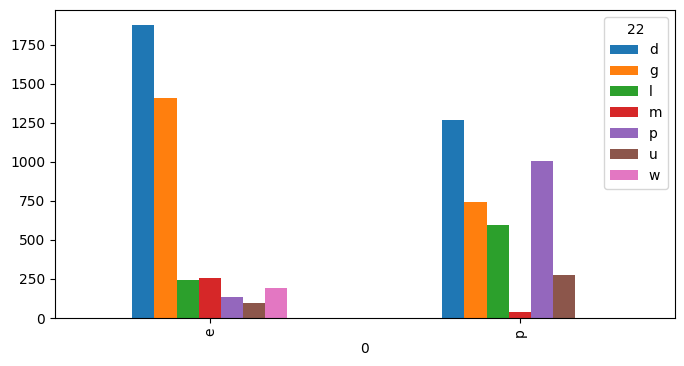

In [13]:
grouped_by_edibility = mushroom_dataframe.groupby(0)

for f in range(1, len(mushroom_dataframe.columns)):
    feature_in_groups = grouped_by_edibility[f].value_counts().unstack().fillna(0)
    feature_in_groups.plot.bar(figsize=(8, 4))

### 2\.1\. Построить решающую функцию

In [14]:
def get_prediction(feature: int) -> pd.DataFrame:
    info_by_feature = mushroom_dataframe.groupby(feature)[0].value_counts().unstack().fillna(0)
    info_by_feature["probability (e)"] = (info_by_feature["e"] + 1) / (info_by_feature["e"] + info_by_feature["p"] + 2)
    info_by_feature["prediction"] = info_by_feature["probability (e)"].map(lambda p: "e" if p >= 0.5 else "p")
    return info_by_feature

results = pd.DataFrame(columns=["Feature", "Errors", "Accuracy"])

for f in range(1, len(mushroom_dataframe.columns)):
    prediction = get_prediction(f)
    error_count = sum(mushroom_dataframe[0] != mushroom_dataframe.apply(lambda row: prediction.loc[row.loc[f]]["prediction"], axis=1))  # noqa
    results.loc[f - 1] = (f, error_count, (len(mushroom_dataframe) - error_count) / len(mushroom_dataframe))

results["Feature"] = pd.to_numeric(results["Feature"], downcast="unsigned")
results["Errors"] = pd.to_numeric(results["Errors"], downcast="unsigned")

display(results[results["Accuracy"] == results["Accuracy"].max()])
results

,Feature,Errors,Accuracy
4,5,120,0.985229


,Feature,Errors,Accuracy
0,1,3540,0.564254
1,2,3408,0.580502
2,3,3288,0.595273
3,4,2080,0.743968
4,5,120,0.985229
5,6,3916,0.517971
6,7,3120,0.615953
7,8,1980,0.756278
8,9,1584,0.805022
9,10,3632,0.552930


### 3\.1\. Построить "наивный" байесовский классификатор из `sklearn`

In [15]:
encoder = LabelEncoder()
encoded_X = mushroom_dataframe.iloc[::, 1:].apply(encoder.fit_transform, result_type="expand")
encoded_y = encoder.fit_transform(mushroom_dataframe.iloc[::, 0])

display(encoded_X)
encoded_y

,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,19,20,21,22
0,5,2,4,1,6,1,0,1,4,0,...,2,7,7,0,2,1,4,2,3,5
1,5,2,9,1,0,1,0,0,4,0,...,2,7,7,0,2,1,4,3,2,1
2,0,2,8,1,3,1,0,0,5,0,...,2,7,7,0,2,1,4,3,2,3
3,5,3,8,1,6,1,0,1,5,0,...,2,7,7,0,2,1,4,2,3,5
4,5,2,3,0,5,1,1,0,4,1,...,2,7,7,0,2,1,0,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,3,2,4,0,5,0,0,0,11,0,...,2,5,5,0,1,1,4,0,1,2
8120,5,2,4,0,5,0,0,0,11,0,...,2,5,5,0,0,1,4,0,4,2
8121,2,2,4,0,5,0,0,0,5,0,...,2,5,5,0,1,1,4,0,1,2
8122,3,3,4,0,8,1,0,1,0,1,...,1,7,7,0,2,1,0,7,4,2


array([1, 0, 0, ..., 0, 1, 0])

In [16]:
classifier = CategoricalNB()
classifier.fit(encoded_X, encoded_y)
classifier_prediction = classifier.predict(encoded_X)

error_count = (classifier_prediction != encoded_y).sum()  # noqa
accuracy = (len(mushroom_dataframe) - error_count) / len(mushroom_dataframe)

display(f"{error_count = }", f"{accuracy = }")

'error_count = 352'

'accuracy = 0.9566715903495815'

### 4\.1\. Построить собственный классификатор

In [17]:
def cond_probability(feature: int) -> pd.DataFrame:
   by_feature = mushroom_dataframe.groupby(feature)[0].value_counts().unstack().fillna(0).T
   return (by_feature + 1).div(by_feature.sum(axis=1) + 2, axis=0)


class HandcraftedNB:
    def fit(self, X: Any, y: Any) -> Any:  # noqa
        self._class_probabilities = y.value_counts() / len(y)  # noqa
        self._cond_probabilities = {  # noqa
            feature: cond_probability(feature)
            for feature in range(1, len(mushroom_dataframe.columns))
        }

    def predict(self, X: Any) -> Any:  # noqa
        predict = np.empty(len(X), dtype=str)
        for idx, row in X.iterrows():
            e = self._class_probabilities["e"]
            p = self._class_probabilities["p"]
            for feature in range(1, len(mushroom_dataframe.columns)):
                e *= self._cond_probabilities[feature].loc["e", row[feature]]
                p *= self._cond_probabilities[feature].loc["p", row[feature]]
            predict[idx] = "e" if e > p else "p"
        return predict

In [18]:
X = mushroom_dataframe.iloc[::, 1:]
y = mushroom_dataframe.iloc[::, 0]

handcrafted_classifier = HandcraftedNB()
handcrafted_classifier.fit(X, y)
classifier_prediction = handcrafted_classifier.predict(X)

error_count = (classifier_prediction != y).sum()  # noqa
accuracy = (len(mushroom_dataframe) - error_count) / len(mushroom_dataframe)

display(f"{error_count = }", f"{accuracy = }")

'error_count = 352'

'accuracy = 0.9566715903495815'

### 5\.1\. Подвергнуть переменные оценки обратному логистическому преобразованию.

In [19]:
mushroom_inverse = mushroom_dataframe.iloc[::, 1:].copy()
count = mushroom_dataframe[0].value_counts()
e = count["e"] / count.sum()
e0 = np.log(e) - np.log(1 - e)

for feature in range(1, len(mushroom_inverse.columns) + 1):
    info_by_feature = mushroom_dataframe.groupby(feature)[0].value_counts().unstack().fillna(0)
    info_by_feature["probability (e)"] = (info_by_feature["e"] + 1) / (info_by_feature["e"] + info_by_feature["p"] + 2)
    p = mushroom_dataframe[feature].map(lambda x: info_by_feature.at[x, "probability (e)"])
    mushroom_inverse[feature] = np.log(p) - np.log(1 - p) - e0

mushroom_inverse

,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,19,20,21,22
0,0.059491,-0.282227,0.142373,1.410778,-5.620993,-0.042102,-0.306625,-2.113002,1.597240,-0.233724,...,0.722320,0.402528,0.403796,-0.000018,-0.044663,-0.106099,1.278554,1.919907,0.798344,-1.106678
1,0.059491,-0.282227,-0.589701,1.410778,5.922045,-0.042102,-0.306625,0.767928,1.597240,-0.233724,...,0.722320,0.402528,0.403796,-0.000018,-0.044663,-0.106099,1.278554,1.976493,5.922045,0.570718
2,2.040150,-0.282227,0.737281,1.410778,5.922045,-0.042102,-0.306625,0.767928,2.043379,-0.233724,...,0.722320,0.402528,0.403796,-0.000018,-0.044663,-0.106099,1.278554,1.976493,5.922045,1.866241
3,0.059491,-0.217584,0.737281,1.410778,-5.620993,-0.042102,-0.306625,-2.113002,2.043379,-0.233724,...,0.722320,0.402528,0.403796,-0.000018,-0.044663,-0.106099,1.278554,1.919907,0.798344,-1.106678
4,0.059491,-0.282227,0.172507,-0.887336,3.266467,-0.042102,2.291605,0.767928,1.597240,0.179287,...,0.722320,0.402528,0.403796,-0.000018,-0.044663,-0.106099,-0.633371,1.976493,5.881327,0.570718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,-1.036790,-0.282227,0.142373,-0.887336,3.266467,2.246334,-0.306625,0.767928,0.966976,-0.233724,...,0.722320,5.190773,5.190773,-0.000018,4.502794,-0.106099,1.278554,3.819904,1.624218,-0.972314
8120,0.059491,-0.282227,0.142373,-0.887336,3.266467,2.246334,-0.306625,0.767928,0.966976,-0.233724,...,0.722320,5.190773,5.190773,-0.000018,4.502794,-0.106099,1.278554,3.819904,-0.942414,-0.972314
8121,-0.046551,-0.282227,0.142373,-0.887336,3.266467,2.246334,-0.306625,0.767928,2.043379,-0.233724,...,0.722320,5.190773,5.190773,-0.000018,4.502794,-0.106099,1.278554,3.819904,1.624218,-0.972314
8122,-1.036790,-0.217584,0.142373,-0.887336,-6.429759,-0.042102,-0.306625,-2.113002,-7.527215,0.179287,...,-2.773509,0.402528,0.403796,-0.000018,-0.044663,-0.106099,-0.633371,-1.216813,-0.942414,-0.972314


### 5\.2\. Применить метод логистической регрессии.

In [21]:
X = mushroom_inverse.loc[::, mushroom_inverse.columns != 5]
y = mushroom_dataframe[0]

classifier = LogisticRegression("l1", solver="liblinear")
classifier.fit(X, y)
classifier_prediction = classifier.predict(X)

error_count = (classifier_prediction != y).sum()  # noqa
accuracy = (len(mushroom_dataframe) - error_count) / len(mushroom_dataframe)

display(f"{error_count = }", f"{accuracy = }")

'error_count = 0'

'accuracy = 1.0'